In [2]:
import pandas as pd

In [6]:
# the autocast results are in the directory above the current directory
autocast_res_dir = "..\\..\\analysis\\nod_embeddings_epoch1_fp32.csv"

regular_res_dir = "..\\..\\analysis\\nod_embeddings_epoch1.csv"

In [8]:
autocast_res = pd.read_csv(autocast_res_dir)

regular_res = pd.read_csv(regular_res_dir)

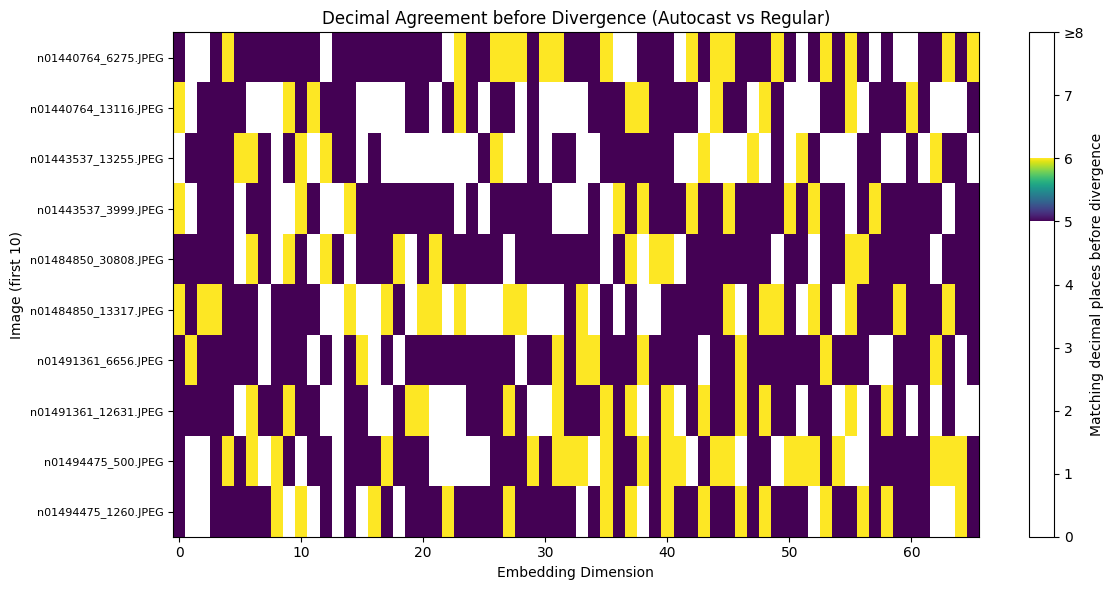

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Set image column as index to align rows if needed
if 'image' in autocast_res.columns:
    autocast_res = autocast_res.set_index('image')
if 'image' in regular_res.columns:
    regular_res = regular_res.set_index('image')

# Select first 10 rows common to both
common_index = autocast_res.index.intersection(regular_res.index)
first_10 = common_index[:10]

autocast_subset = autocast_res.loc[first_10]
regular_subset = regular_res.loc[first_10]

# Focus on numeric columns only
numeric_cols = autocast_subset.select_dtypes(include='number').columns
autocast_numeric = autocast_subset[numeric_cols]
regular_numeric = regular_subset[numeric_cols]

abs_diff = (autocast_numeric - regular_numeric).abs().to_numpy()

with np.errstate(divide='ignore'):
    divergence = -np.log10(abs_diff)

# exact matches -> denote as NaN (no divergence)
divergence[np.isinf(divergence)] = np.nan

# Convert to "matching decimal places" by flooring and clipping
divergence = np.floor(divergence)
divergence[divergence < 0] = 0

max_decimals = 8
heatmap_values = np.clip(divergence, a_min=None, a_max=max_decimals)

plt.figure(figsize=(12, 6))
plt.imshow(heatmap_values, aspect='auto', cmap='viridis')
cb = plt.colorbar(label='Matching decimal places before divergence')
cb.set_ticks(range(max_decimals + 1))
cb.set_ticklabels([str(i) for i in range(max_decimals)] + ['≥8'])
plt.xlabel('Embedding Dimension')
plt.ylabel('Image (first 10)')
plt.yticks(ticks=np.arange(len(first_10)), labels=first_10, fontsize=8)
plt.title('Decimal Agreement before Divergence (Autocast vs Regular)')
plt.tight_layout()
plt.show()



In [15]:
# Verify that image columns are identical and in the same order
images_autocast = autocast_res.reset_index()['image'] if 'image' in autocast_res.columns else autocast_res.index.to_series().reset_index(drop=True)
images_regular = regular_res.reset_index()['image'] if 'image' in regular_res.columns else regular_res.index.to_series().reset_index(drop=True)

same_images = images_autocast.equals(images_regular)

if same_images:
    print('Image columns match exactly and are in the same order.')
else:
    # Identify differing rows
    diff_mask = images_autocast != images_regular
    diff_indices = diff_mask[diff_mask].index
    print(f'Image columns differ at {len(diff_indices)} positions.')

    # Compare sets per category to see if they match as permutations
    cat_autocast = autocast_res.reset_index()[['image', 'category']] if 'category' in autocast_res.columns else None
    cat_regular = regular_res.reset_index()[['image', 'category']] if 'category' in regular_res.columns else None

    mismatched_categories = []
    if cat_autocast is not None and cat_regular is not None:
        for category in cat_autocast['category'].unique():
            auto_imgs = set(cat_autocast.loc[cat_autocast['category'] == category, 'image'])
            reg_imgs = set(cat_regular.loc[cat_regular['category'] == category, 'image'])
            if auto_imgs != reg_imgs:
                mismatched_categories.append(category)
        if mismatched_categories:
            print('Categories with differing image sets:')
            for cat in mismatched_categories[:10]:
                print(f'  {cat}')
            if len(mismatched_categories) > 10:
                print('  ...')
        else:
            print('Image sets match within each category (differences are due to ordering).')

    # Optionally, show first few mismatched rows
    for idx in diff_indices[:10]:
        print(f'  Row {idx}: autocast={images_autocast.iloc[idx]!r}, regular={images_regular.iloc[idx]!r}')
    if len(diff_indices) > 10:
        print('  ...')



Image columns differ at 992 positions.
Categories with differing image sets:
  n02095889
  n03223299
  n04532670
  Row 2: autocast='n01443537_13255.JPEG', regular='n01443537_3999.JPEG'
  Row 3: autocast='n01443537_3999.JPEG', regular='n01443537_13255.JPEG'
  Row 10: autocast='n01496331_12164.JPEG', regular='n01496331_4208.JPEG'
  Row 11: autocast='n01496331_4208.JPEG', regular='n01496331_12164.JPEG'
  Row 18: autocast='n01518878_1363.JPEG', regular='n01518878_39547.JPEG'
  Row 19: autocast='n01518878_39547.JPEG', regular='n01518878_1363.JPEG'
  Row 20: autocast='n01530575_10367.JPEG', regular='n01530575_6550.JPEG'
  Row 21: autocast='n01530575_6550.JPEG', regular='n01530575_10367.JPEG'
  Row 22: autocast='n01531178_12895.JPEG', regular='n01531178_4486.JPEG'
  Row 23: autocast='n01531178_4486.JPEG', regular='n01531178_12895.JPEG'
  ...


In [ ]:
from pathlib import Path

analysis_dir = Path.cwd().parents[1] / "analysis"
nod_2k_images = pd.read_csv(analysis_dir / "nod_2k_images.csv")
print(nod_2k_images["image"].nunique())


2000
